# Problem Statement

We are provided with data from an online personal loan platform. Given a set of attributes for an individual, we need to determine if a credit line should be extended to them and if yes what should the repayment terms be.

Concepts Used: Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split,KFold,cross_val_score)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,confusion_matrix,
                             roc_auc_score,roc_curve,auc,
                             precision_recall_curve,classification_report)

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
data=pd.read_csv("loan.csv")
data.head()

# Preliminary data analysis

In [ ]:
data.shape

(396030, 27)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  int64  
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [ ]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

*There are a few missing values for some columns in a few rows. Columns "issue_d" and "earliest_cr_line" are strings which ideally should be datetime. Target variable is "loan_status".*

In [ ]:
data.describe(include='object').T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173103,Teacher,4389
emp_length,377729,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-14,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


In [ ]:
data.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


## Analysing Categorical Variables

In [ ]:
data['loan_status'].value_counts()

loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64

In [ ]:
data['loan_status'].value_counts()/len(data)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: count, dtype: float64

More than 80% of the people fully paid the loan back and close to 20% are charged off.

In [ ]:
data['term'].value_counts()

term
 36 months    302005
 60 months     94025
Name: count, dtype: int64

In [ ]:
data['emp_title'].value_counts()

emp_title
Teacher                    4389
Manager                    4250
Registered Nurse           1856
RN                         1846
Supervisor                 1830
                           ... 
sikorsky                      1
Postman                       1
McCarthy & Holthus, LLC       1
jp flooring                   1
Gracon Services, Inc          1
Name: count, Length: 173103, dtype: int64

In [ ]:
data['emp_length'].value_counts()

emp_length
10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: count, dtype: int64

In [ ]:
data['purpose'].value_counts()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: count, dtype: int64

In [ ]:
data['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

Majority have home_ownership as "Mortgage"

In [ ]:
data['application_type'].value_counts()

application_type
INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: count, dtype: int64

"Individual" applications are most requested. Mostly people who has 10+ years of employment request for loan. Among professions "Teachers" and "Managers" stand top in loan application requests. "36 months" term is more common than "60 months". Under "home_ownership" Other,None,Any can be merged into one single category "Other"

In [ ]:
data.groupby(by=['grade','loan_status']).size()

grade  loan_status
A      Charged Off      4036
       Fully Paid      60151
B      Charged Off     14587
       Fully Paid     101431
C      Charged Off     22449
       Fully Paid      83538
D      Charged Off     18338
       Fully Paid      45186
E      Charged Off     11765
       Fully Paid      19723
F      Charged Off      5037
       Fully Paid       6735
G      Charged Off      1461
       Fully Paid       1593
dtype: int64

People with grade B are more likely to fully pay their loan.

## Visual analysis

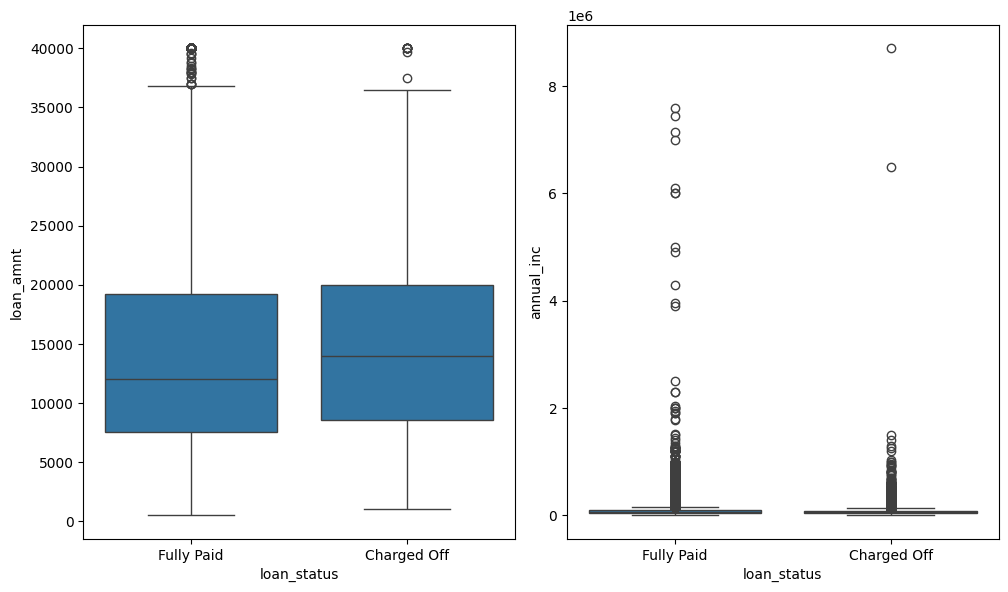

In [ ]:
num=['loan_amnt','annual_inc']
cat=['loan_status']

plt.figure(figsize=(15,6))
for i,j in enumerate(num):
  plt.subplot(1,3,i+1)
  plt.subplots_adjust(hspace=0.8)
  sns.boxplot(x='loan_status',y=j,data=data)
  plt.tight_layout(pad=1)


From the above box plot, what we understand is loan amount alone can't determine the creditworthiness. Also most of the people who approach for loan has annual income less than 1 lakh.

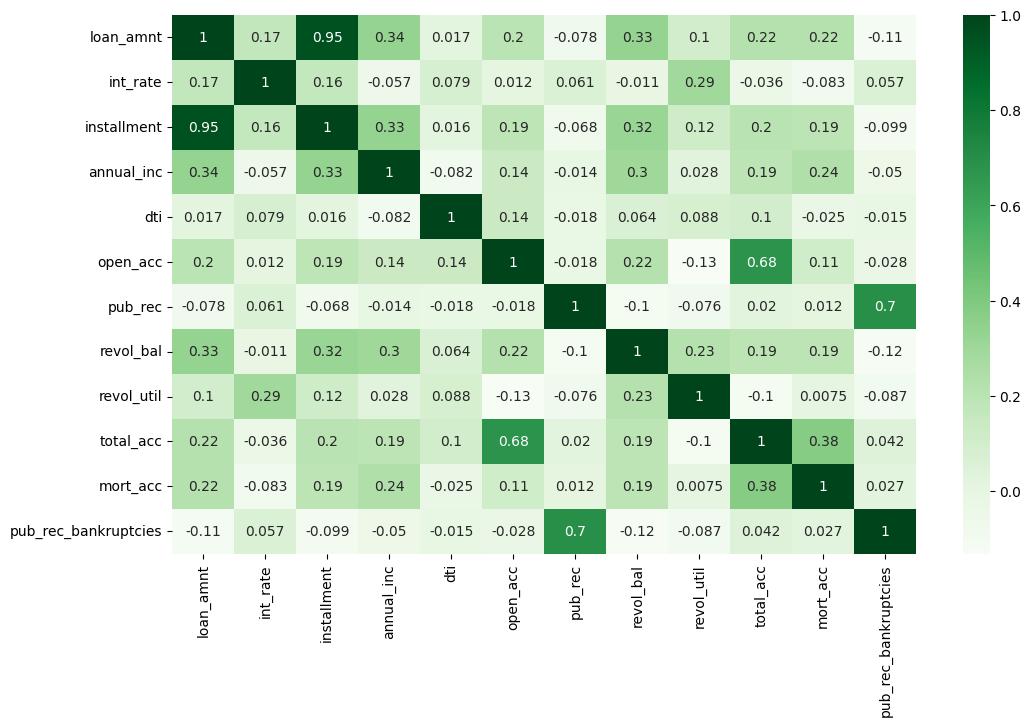

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(data.corr(numeric_only=True),annot=True,cmap='Greens')
plt.show()

"Installment" and "loan_amount" are closely related as installment is calculated based on loan amount and tenure. Infact we need to keep only one column and can remove installment column.

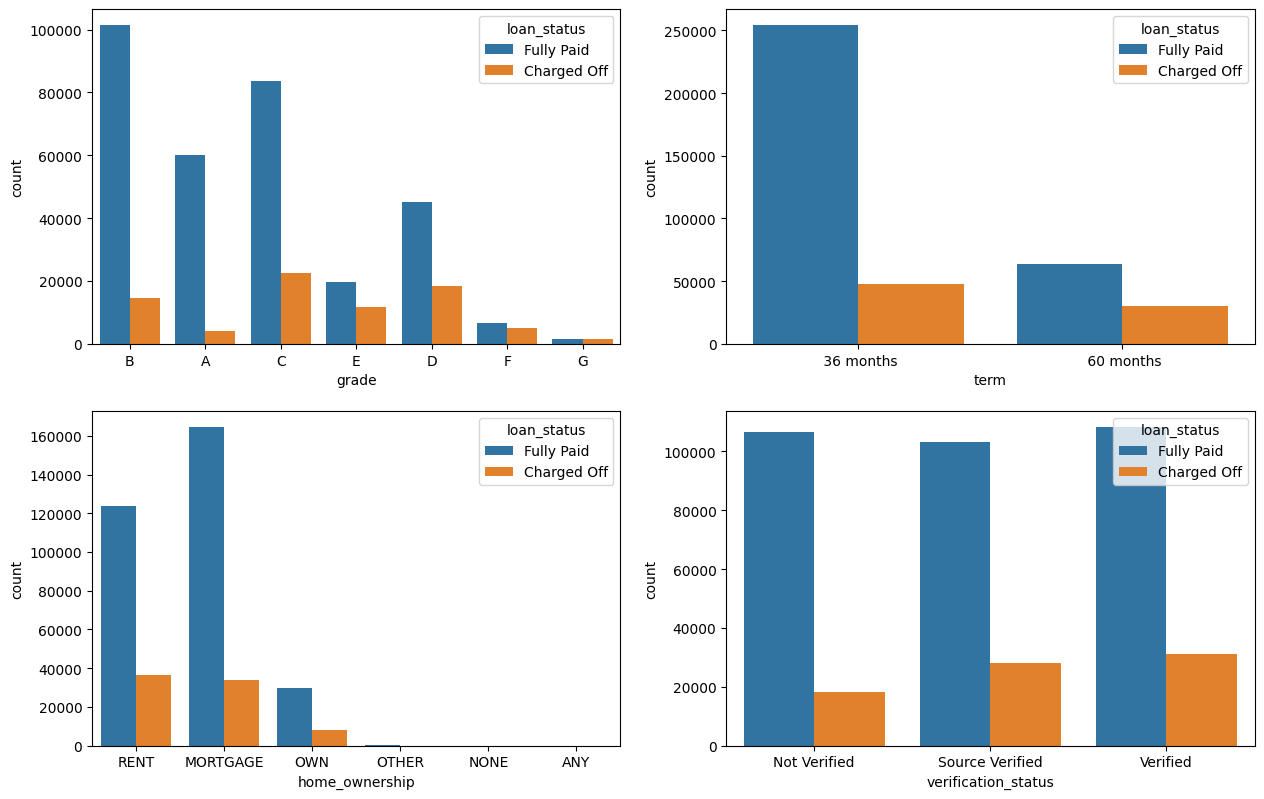

In [ ]:
cat=['grade','term','home_ownership','verification_status']

plt.figure(figsize=(15,20))
for i,j in enumerate(cat):
  plt.subplot(4,2,i+1)
  sns.countplot(x=j,hue='loan_status',data=data)

<ipython-input-107-f75570a401a2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_xticklabels(pl.get_xticklabels(),rotation=90)
<ipython-input-107-f75570a401a2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_xticklabels(pl.get_xticklabels(),rotation=90)


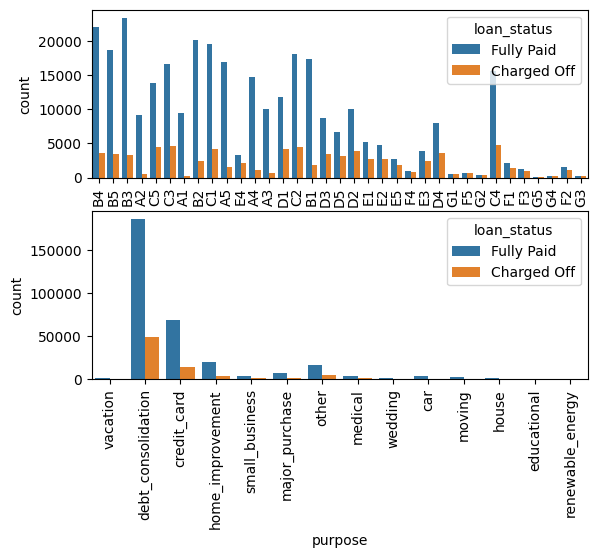

In [ ]:

cat=['sub_grade','purpose']
for i,j in enumerate(cat):
  plt.subplot(2,1,i+1)
  pl=sns.countplot(x=j,data=data,hue='loan_status')
  pl.set_xticklabels(pl.get_xticklabels(),rotation=90)

## Data Cleaning and Feature Engineering

In [ ]:
## Dropping "installment" column

data.drop(columns=["installment"],axis=1,inplace=True)
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [ ]:
## Combining minority classes of "home_ownership"

data.loc[(data["home_ownership"]=="ANY") | (data["home_ownership"]=="NONE"),"home_ownership"]="OTHER"
data['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

In [ ]:
## Mapping of target variable
data['loan_status']=data['loan_status'].map({'Fully Paid':0,'Charged Off':1})

In [ ]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [ ]:
def fun(number):
  if number==0.0:
    return 0
  else:
    return 1

def fun2(number):
  if number==0.0:
    return 0
  elif number>=1.0:
    return 1
  else:
    return number    ## There are missing values

data['pub_rec']=data['pub_rec'].apply(fun)
data['mort_acc']=data['mort_acc'].apply(fun2)
data['pub_rec_bankruptcies']=data['pub_rec_bankruptcies'].apply(fun2)

In [ ]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [ ]:
## Converting categorical into numerical
data['term']=data['term'].map({' 36 months':36,' 60 months':60})
data.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000,36,11.44,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,...,16,0,36369,41.8,25,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000,36,11.99,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,...,17,0,20131,53.3,27,f,INDIVIDUAL,1.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600,36,10.49,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,...,13,0,11987,92.2,26,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200,36,6.49,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,...,6,0,5472,21.5,13,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375,60,17.27,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,...,13,0,24584,69.8,43,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
data['term'].unique()

array([36, 60])

In [ ]:
## Mean target imputation
total_acc_avg=data.groupby(by='total_acc').mean(numeric_only=True)['mort_acc']
# print(total_acc_avg)
# print(data['total_acc'].nunique(),data['total_acc'].min(),data['total_acc'].max())

def fill_mort_acc(total_acc,mort_acc):
  if np.isnan(mort_acc):
    # print(total_acc)
    return total_acc_avg[total_acc].round()
  else:
    return mort_acc

# print(data[['total_acc','mort_acc']])
data['mort_acc']=data.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [ ]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [ ]:
## Extracting zip code from address
data['zip_code']=data['address'].apply(lambda x:x[-5:])
data['zip_code'].value_counts(normalize=True)*100

zip_code
70466    14.389061
30723    14.278211
22690    14.273414
48052    14.119385
00813    11.570841
29597    11.481706
05113    11.464283
11650     2.834634
93700     2.815696
86630     2.772770
Name: proportion, dtype: float64

In [ ]:
## Dropping a few columns which might not be so useful

data.drop(columns=['issue_d','emp_title','title','sub_grade','address','earliest_cr_line','emp_length'],axis=1,inplace=True)

In [ ]:
## Outlier removal

num_cols=data.select_dtypes(include=np.number).columns
for col in num_cols:
  mu=data[col].mean()
  sigma=data[col].std()

  upper_limit=mu+3*sigma
  lower_limit=mu-3*sigma

  data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]

data.shape

(378197, 20)

In [ ]:
## Dropping remaining rows with null values
data.dropna(inplace=True)
data.isnull().sum()/len(data)*100

<ipython-input-124-7e65ae822498>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
zip_code                0.0
dtype: float64

In [ ]:
data['initial_list_status']=data['initial_list_status'].map({'w':0,'f':1})

## One hot encoding

dummies=['purpose','zip_code','home_ownership','grade','verification_status','application_type']
data=pd.get_dummies(data,columns=dummies,drop_first=True)

In [ ]:
## Train test split
X=data.drop('loan_status',axis=1)
y=data['loan_status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)

(264737, 48)
(113460, 48)


In [ ]:
X_train.head()

In [ ]:
## Scaling
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# Logistic regression

In [ ]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred=logreg.predict(X_test)


## Performance evaluation

In [ ]:
## Confusion Matrix
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[90532   633]
 [12005 10290]]


In [ ]:
## Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     91165
           1       0.94      0.46      0.62     22295

    accuracy                           0.89    113460
   macro avg       0.91      0.73      0.78    113460
weighted avg       0.89      0.89      0.87    113460



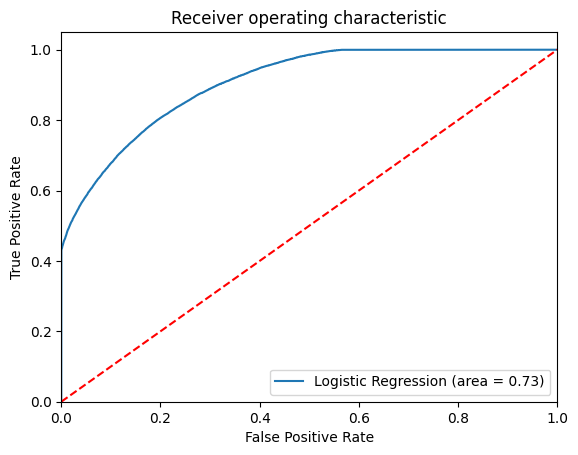

In [ ]:
## ROC-AUC Curve
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)'%logit_roc_auc)
plt.plot([0,1], [0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

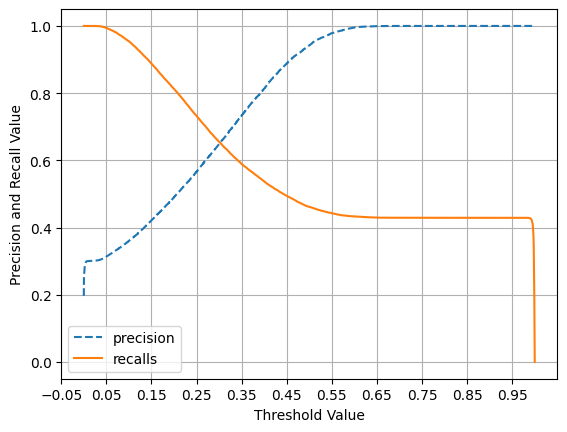

In [ ]:
## Precision Recall curve

def precision_recall_curve_plot(y_test,pred_proba_c1):
  precisions,recalls,thresholds=precision_recall_curve(y_test,pred_proba_c1)
  threshold_boundary=thresholds.shape[0]
  # plot precision
  plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
  # plot recall
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlabel('Threshold Value');
  plt.ylabel('Precision and Recall Value')
  plt.legend();
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

In [ ]:
## Cross validation
X=scaler.fit_transform(X)
kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(logreg,X,y,cv=kfold,scoring='accuracy'))
print("Cross Validation accuracy: {:.3f}".format(accuracy))

Cross Validation accuracy: 0.889


## Actionable insights and recommendations

-> Around 80.26% of customers have fully paid their Loan Amount. The defaulters are ~ 20%. From Personal loan business perspective this ratio is high. These 20% will contribute in NPAs of LoanTap. To reduce the risk of NPAs,
company should add slightly stringent rules to bring down this ratio to 5% to 6%.

-> Overall Statistics of the Model:
Accuracy = 89%
Precision = 88
Recall = 99
F1 -score = 93%
Model created has high values for accuracy, precision, recall & f1-score. This means, this model is a good classifier. Overall, it has good prediction capability in identifying right customers (which can be easily converted).
However this model has slightly low capability on correctly identifying defaulters.

-> Features which have significant impact on outcome are as follow:

Interest Rate, loan grade and subgrade, term, home_ownership, purpose,application_type, pincode, emp_title, emp_length

-> "Individual" applications are most requested. Mostly people who has 10+ years of employment request for loan. Among professions "Teachers" and "Managers" stand top in loan application requests. "36 months" term is more common than "60 months". People with grade B are more likely to fully pay their loan. Also most of the people who approach for loan has annual income less than 1 lakh.

-> Company should focus more on Loans for shorter duration. Company can also decide their social media based marketing based on person's job-titles.
Pincode based market segmentation should also be included

1. Around 80.38% of customers have fully paid their Loan Amount.

2.  There is very high co-relation between loan amount and installment. pearson co-efficient is ~ 0.95. This indicates high multi-collinearity between these two features. Hence installment column is dropped while creating model.

3.  The majority of people have home ownership as Mortaged

4. People with grade B are more likely to fully pay their loan.

5.  Top 2 afforded job titles are Teacher and Manager

6.  About performance metrics:

ROC-AUC : Not good metric to consider as we have highly imbalanced data.

Precision: Consider when only want to reduce NPA

Recall: Consider when we do not want to miss good opportunity for providing loan to customer

F1-score: Good metric because we want to consider both Precision and Recall.

7.  Recall score: 0.98 and Precision score: 0.81. That means there are more false positives than the false negatives.

If Recall value is low,  it means Bank is loosing in opportunity cost.

If Precision value is low, it means Bank's NPA (defaulters) may increase.

8. The features that heavily affected the outcome

Loan sub-grade

Annual Income

Interest rate

Mortgaged accounts

Purpose

Application Type

Employment Length

Home Ownership

term : number of payments on the loan

debt to income ratio
     
9. Results are affected by geographical location. Few states have high chances of getting loan compare to other states.
